In [4]:
#Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Read the data
df = pd.read_csv("playlist_2010to2022.csv")

In [6]:
# List the data types 
df.dtypes

playlist_url          object
year                   int64
track_id              object
track_name            object
track_popularity       int64
album                 object
artist_id             object
artist_name           object
artist_genres         object
artist_popularity      int64
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
time_signature       float64
dtype: object

In [7]:
# Analyse Track Popularity and Duration
track_pop_by_duration = df.loc[:,["track_popularity","duration_ms"]]
track_pop_by_duration

,track_popularity,duration_ms
0,91,266773.0
1,84,167067.0
2,69,250547.0
3,88,216880.0
4,74,200400.0
...,...,...
2295,79,239027.0
2296,69,172540.0
2297,86,97393.0
2298,77,136267.0


In [8]:
# Find column with NA value
nan_indices = track_pop_by_duration.columns[track_pop_by_duration.isna().any()].tolist()
nan_indices

['duration_ms']

In [9]:
# Clean the data and rename the cols
cleaned_dataset = track_pop_by_duration.loc[~track_pop_by_duration['duration_ms'].isna()]
cleaned_dataset.columns = ['popularity', 'duration']
cleaned_dataset

,popularity,duration
0,91,266773.0
1,84,167067.0
2,69,250547.0
3,88,216880.0
4,74,200400.0
...,...,...
2295,79,239027.0
2296,69,172540.0
2297,86,97393.0
2298,77,136267.0


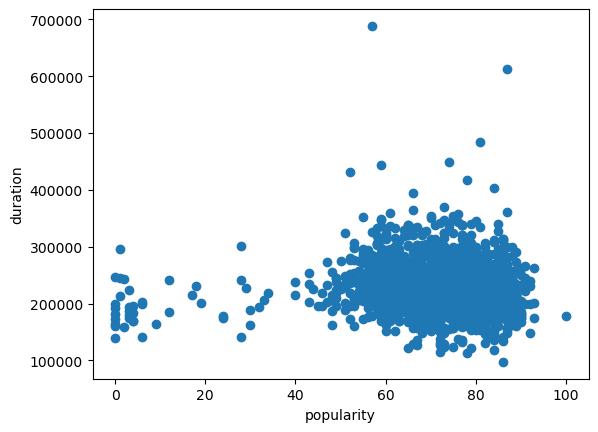

In [10]:
# Visuallise data using scatter plot
plt.scatter(cleaned_dataset['popularity'],cleaned_dataset['duration'])
plt.xlabel('popularity')
plt.ylabel('duration')
plt.show()

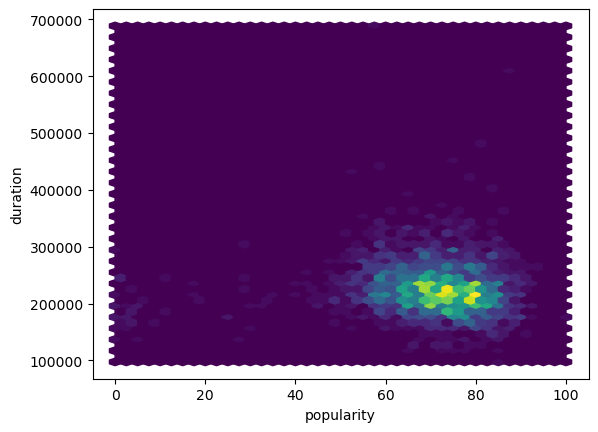

In [11]:
# Visualise data using hexbin plot
plt.hexbin(cleaned_dataset['popularity'],cleaned_dataset['duration'], gridsize=(40,30))
plt.xlabel('popularity')
plt.ylabel('duration')
plt.show()

In [12]:
# Analyse Track Popularity by Artist Popularity
track_pop_by_artist_pop = df.loc[:,['track_popularity','artist_popularity']]
track_pop_by_artist_pop

,track_popularity,artist_popularity
0,91,86
1,84,75
2,69,61
3,88,83
4,74,65
...,...,...
2295,79,86
2296,69,85
2297,86,82
2298,77,84


In [13]:
# Check if there's any NA values
track_pop_by_artist_pop.columns[track_pop_by_artist_pop.isna().any()].tolist()

[]

In [14]:
# Rename cols
track_pop_by_artist_pop.columns = ['track_pop','artist_pop']

In [15]:
# import ML model
from sklearn import metrics

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [16]:
y = track_pop_by_artist_pop.track_pop
x = track_pop_by_artist_pop[['artist_pop']]

In [17]:
# Fit the linear regression model
linr_model = LinearRegression().fit(x,y)
linr_model

LinearRegression()

In [19]:
y_pred = linr_model.predict(x)

In [20]:
# Evaluate the model
r2_score(y,y_pred)

0.10960268418796082

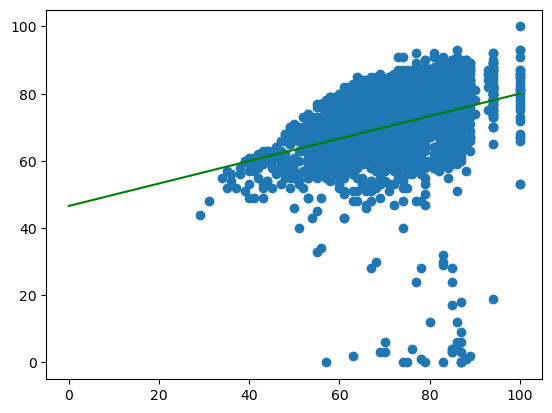

In [21]:
# Plot the resulting line
plt.scatter(track_pop_by_artist_pop['artist_pop'],track_pop_by_artist_pop['track_pop'])
plt.xlabel = 'track_popularity'
plt.ylabel = 'artist_popularity'
x = np.linspace(0, 100, 1000)
plt.plot(x, x*linr_model.coef_[0] + linr_model.intercept_, color = "green")
plt.show()

In [22]:
# Remove outlier to improve prediction
def remove_outliers(dataframe):
    return dataframe.loc[dataframe['track_pop'] >= 40]
track_pop_by_artist_pop = remove_outliers(track_pop_by_artist_pop)
len(track_pop_by_artist_pop)

2258

In [24]:
# Re-apply linear regression model
y = track_pop_by_artist_pop.track_pop
x = track_pop_by_artist_pop[['artist_pop']]
linr_model_2 = LinearRegression().fit(x,y)

In [25]:
# Re-evaluate model
y_pred_2 = linr_model_2.predict(x)
r2_score(y,y_pred_2)

0.27848752409366817

In [27]:
from sklearn.utils.fixes import parse_version, sp_version

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
y = track_pop_by_artist_pop.track_pop
x = track_pop_by_artist_pop[['artist_pop']]

In [28]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
# x,y values for the mean line
x_0 = np.linspace(30, 100, 2258)
y_true_mean = x_0*linr_model_2.coef_[0] + linr_model_2.intercept_

# set the default outbound predictions to all zeros
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)

x = np.array(x).reshape(-1,1)
# Draw lines and sections for each quantile
for quantile in quantiles:
    # Fit the model and find the fitted line for each quantile
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(x, y).predict(x)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y
        )

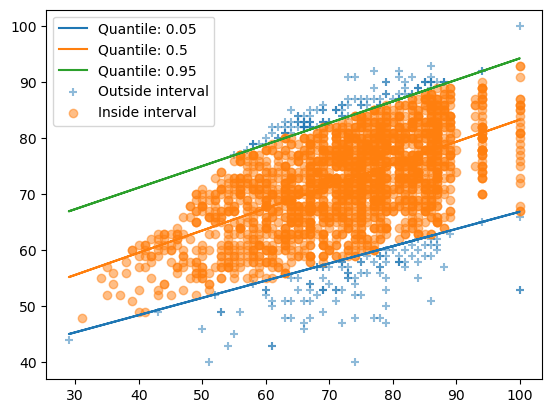

In [29]:

# Plot the result
for quantile, y_pred in predictions.items():
    plt.plot(x, y_pred, label=f"Quantile: {quantile}")

# outside the interval
plt.scatter(
    x[out_bounds_predictions],
    y[out_bounds_predictions],
    marker="+",
    alpha=0.5,
    label="Outside interval", 
)
# inside the interval
plt.scatter(
    x[~out_bounds_predictions],
    y[~out_bounds_predictions],
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.show()